# Exploring player groupings using K-means for 2017/18 season

## Purpose

The purpose of this notebook is to:

- Create a complete dataset for all stats for all players in the Premier League in 2017/18 season
	- Potentially create a process for combining all datasets from the same source into a complete dataset for each year
- Investigate and see if there are any logical groupings/cluster present based solely on the data (excluding assigned position and team)
- Investigate the similarities between the players in each cluster

## Data sources

- [Standard Stats](https://fbref.com/en/comps/9/2017-2018/stats/2017-2018-Premier-League-Stats)
- [Goalkeeping Stats](https://fbref.com/en/comps/9/2017-2018/keepers/2017-2018-Premier-League-Stats)
- [Shooting Stats](https://fbref.com/en/comps/9/2017-2018/shooting/2017-2018-Premier-League-Stats)
- [Passing Stats](https://fbref.com/en/comps/9/2017-2018/passing/2017-2018-Premier-League-Stats)
- [Defensive Stats](https://fbref.com/en/comps/9/2017-2018/defense/2017-2018-Premier-League-Stats)
- [Possession Stats](https://fbref.com/en/comps/9/2017-2018/possession/2017-2018-Premier-League-Stats)

## Method

### Import relevant packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import plotly.express as px

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

### Import relevant datasets

In [3]:
goalkeeping = pd.read_csv("../historic_player_stats/2017-2018/goalkeeping.csv")
defensive_actions = pd.read_csv("../historic_player_stats/2017-2018/defensive_actions.csv")
passing = pd.read_csv("../historic_player_stats/2017-2018/passing.csv")
possession = pd.read_csv("../historic_player_stats/2017-2018/possession.csv")
shooting = pd.read_csv("../historic_player_stats/2017-2018/shooting.csv")
standard = pd.read_csv("../historic_player_stats/2017-2018/standard.csv")

In [4]:
standard.head()

,player,position,team,matches_played,starts,minutes_played,90s,goals,assists,goals+assists,non_penalty_goals,penalties_scored,penalties_attempted,yellow_cards,red_cards,expected_goals,non_penalty_expected_goals,expected_assisted_goals,non_penalty_expected_goals+expected_assisted_goals,progressive_carries,progressive_passes,progressive_passes_recieved
0,Patrick van Aanholt,DF,Crystal Palace,28,25,2184,24.3,5,1,6,5,0,0,7,0,3.1,3.1,2.1,5.2,46.0,92.0,86.0
1,Rolando Aarons,"MF,FW",Newcastle Utd,4,1,139,1.5,0,0,0,0,0,0,0,0,0.1,0.1,0.0,0.1,7.0,3.0,4.0
2,Tammy Abraham,FW,Swansea City,31,15,1726,19.2,5,1,6,5,0,0,0,0,6.8,6.8,1.6,8.4,19.0,20.0,104.0
3,Charlie Adam,MF,Stoke City,11,5,411,4.6,0,0,0,0,0,1,2,1,1.6,0.9,1.2,2.1,6.0,30.0,9.0
4,Adrián,GK,West Ham,19,19,1710,19.0,0,0,0,0,0,0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Dataset Creation

Joining all datasets, bar goalkeeping stats to create a single complete dataset

In [5]:
complete = standard.merge(passing, on=["player", "position", "team"], how='inner')
complete = complete.merge(shooting, on=["player", "position", "team"], how='inner')
complete = complete.merge(possession, on=["player", "position", "team"], how='inner')
complete = complete.merge(defensive_actions, on=["player", "position", "team"], how='inner')

print("New dataframe dimensions: " + str(complete.shape))

New dataframe dimensions: (529, 79)


Join the goalkeeping dataset to the main set, filling the missing rows with zeros for the columns only in the goalkeeping dataset

In [6]:
goalkeeping

,player,position,team,goals_against,shots_on_target_against,saves,wins,draws,losses,clean_sheets,penalties_faced,penalties_allowed,penalties_saved,penalties_missed
0,Adrián,GK,West Ham,29,96,68,7,6,6,6,1,1,0,0
1,Asmir Begović,GK,Bournemouth,61,170,109,11,11,16,6,3,2,1,0
2,Claudio Bravo,GK,Manchester City,1,5,4,2,0,0,2,0,0,0,0
3,Jack Butland,GK,Stoke City,61,201,142,7,11,17,6,5,5,0,0
4,Willy Caballero,GK,Chelsea,4,11,7,1,1,1,1,0,0,0,0
5,Petr Čech,GK,Arsenal,48,135,85,16,6,12,11,6,5,1,0
6,Thibaut Courtois,GK,Chelsea,34,106,74,20,6,9,15,2,2,0,0
7,Karl Darlow,GK,Newcastle Utd,15,47,34,1,5,4,2,3,3,0,0
8,Martin Dúbravka,GK,Newcastle Utd,11,37,25,6,1,5,4,1,0,1,0
9,Ederson,GK,Manchester City,26,80,54,30,4,2,16,2,0,2,0


In [7]:
goalkeeping_columns = goalkeeping.columns.to_list()
complete = complete.merge(goalkeeping, on=['player', 'position', 'team'], how='outer')

In [8]:
complete.head()

,player,position,team,matches_played,starts,minutes_played,90s,goals_x,assists,goals+assists,non_penalty_goals,penalties_scored,penalties_attempted,yellow_cards,red_cards,expected_goals,non_penalty_expected_goals,expected_assisted_goals_x,non_penalty_expected_goals+expected_assisted_goals,progressive_carries,progressive_passes_x,progressive_passes_recieved,total_passing_distance,total_progressive_passing_distance,short_passes_completed,short_passes_attempted,medium_passes_completed,medium_passes_attempted,long_passes_completed,long_passes_attempted,expected_assisted_goals_y,expected_assists,assists-expected_assisted_goals,key_passes,passes_into_final_third,passes_into_penalty_area,crosses_into_penalty_area,progressive_passes_y,goals_y,shots,shots_on_target,goals/shots,goals/shots_on_target,average_shot_distance,shots_from_free_kicks,shots_from_penalties,non_penalty_expected_goals/shots,goals-expected_goals,non_penalty_goals-non_penalty_expected_goals,touches,touches_in_defensive_penalty_area,touches_in_defensive_third,touches_in_middle_third,touches_in_attacking_third,touches_in_attacking_penalty_area,live_ball_touches,take_ons_attempted,take_ons_succeeded,times_tackled_during_take_on,carries,total_carrying_distance,progressive_carrying_distance,carries_into_final_third,carries_into_penalty_area,miscontrols,dispossessed,passes_received,tackles,tackles_won,defensive_third_tackles,middle_third_tackles,attacking_third_tackles,dribblers_tackled,dribbler_tackles_attempted,shots_blocked,passes_blocked,interceptions,clearances,errors_leading_to_shot,goals_against,shots_on_target_against,saves,wins,draws,losses,clean_sheets,penalties_faced,penalties_allowed,penalties_saved,penalties_missed
0,Patrick van Aanholt,DF,Crystal Palace,28,25,2184,24.3,5,1,6,5,0,0,7,0,3.1,3.1,2.1,5.2,46.0,92.0,86.0,14197.0,6422.0,479.0,532.0,311.0,431.0,74.0,152.0,2.1,1.8,-1.1,18.0,63.0,28.0,6.0,92.0,5,33.0,11,0.15,0.45,23.4,4.0,0,0.09,1.9,1.9,1435.0,90.0,445.0,616.0,391.0,32.0,1435.0,31.0,26.0,5.0,717.0,3714.0,1966.0,33.0,7.0,37.0,18.0,711.0,47.0,32.0,29.0,15.0,3.0,16.0,34.0,5.0,19.0,47.0,64.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Rolando Aarons,"MF,FW",Newcastle Utd,4,1,139,1.5,0,0,0,0,0,0,0,0,0.1,0.1,0.0,0.1,7.0,3.0,4.0,376.0,77.0,24.0,30.0,2.0,5.0,2.0,3.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,3.0,0,2.0,0,0.00,NaN,19.9,0.0,0,0.03,-0.1,-0.1,65.0,0.0,11.0,30.0,25.0,3.0,65.0,6.0,4.0,2.0,37.0,380.0,127.0,3.0,3.0,4.0,6.0,39.0,4.0,4.0,3.0,1.0,0.0,4.0,6.0,0.0,3.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Tammy Abraham,FW,Swansea City,31,15,1726,19.2,5,1,6,5,0,0,0,0,6.8,6.8,1.6,8.4,19.0,20.0,104.0,2754.0,557.0,123.0,173.0,56.0,89.0,10.0,22.0,1.6,0.8,-0.6,12.0,16.0,6.0,2.0,20.0,5,42.0,13,0.12,0.38,13.1,0.0,0,0.16,-1.8,-1.8,498.0,12.0,33.0,246.0,230.0,65.0,498.0,47.0,27.0,20.0,305.0,1600.0,555.0,16.0,8.0,50.0,51.0,393.0,10.0,8.0,1.0,7.0,2.0,1.0,13.0,1.0,7.0,1.0,11.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Charlie Adam,MF,Stoke City,11,5,411,4.6,0,0,0,0,0,1,2,1,1.6,0.9,1.2,2.1,6.0,30.0,9.0,3889.0,1505.0,51.0,66.0,72.0,96.0,45.0,107.0,1.2,1.4,-1.2,6.0,28.0,7.0,4.0,30.0,0,9.0,2,0.00,0.00,31.5,3.0,0,0.09,-1.6,-0.9,342.0,9.0,58.0,218.0,76.0,5.0,341.0,12.0,12.0,0.0,206.0,960.0,436.0,15.0,2.0,7.0,5.0,211.0,9.0,5.0,2.0,5.0,2.0,5.0,17.0,0.0,2.0,9.0,11.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Adrián,GK,West Ham,19,19,1710,19.0,0,0,0,0,0,0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11798.0,10438.0,12.0,12.0,51.0,52.0,203.0,503.0,0.0,0.1,0.0,0.0,13.0,1.0,0.0,0.0,0,0.0,0,NaN,NaN,NaN,0.0,0,NaN,0.0,0.0,641.0,541.0,633.0,9.0,0.0,0.0,641.0,0.0,0.0,0.0,284.0,2193.0,1505.0,0.0,0.0,0.0,0.0,166.0,2.0,1.0,2.0,0.0,0.0,1.0,4.0,0.0,1.0,0.0,15.0,1.0,29.0,96.0,68.0,7.0,6.0,6.0,6.0,1.0,1.0,0.0,0.0


### EDA

#### Remove columns with operations

To reduce the number of features shown in the table originally. As these columns are generated with dta available in the table, they are not initially required, and can be recreated if required

In [9]:
operation_characters = set("/-+*")
columns_to_remove = [col for col in complete.columns if any(char in col for char in operation_characters)]

complete_without_calculated_columns = complete.drop(columns=columns_to_remove)

print(f"Number of Features reduced from {str(len(complete.columns))} to {str(len(complete_without_calculated_columns.columns))}")
print("\nFeatures removed:\n")
print("\n".join(columns_to_remove))


Number of Features reduced from 90 to 82

Features removed:

goals+assists
non_penalty_expected_goals+expected_assisted_goals
assists-expected_assisted_goals
goals/shots
goals/shots_on_target
non_penalty_expected_goals/shots
goals-expected_goals
non_penalty_goals-non_penalty_expected_goals


In [10]:
complete_without_calculated_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 82 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   player                              529 non-null    object 
 1   position                            529 non-null    object 
 2   team                                529 non-null    object 
 3   matches_played                      529 non-null    int64  
 4   starts                              529 non-null    int64  
 5   minutes_played                      529 non-null    int64  
 6   90s                                 529 non-null    float64
 7   goals_x                             529 non-null    int64  
 8   assists                             529 non-null    int64  
 9   non_penalty_goals                   529 non-null    int64  
 10  penalties_scored                    529 non-null    int64  
 11  penalties_attempted                 529 non-n

#### Remove duplicated columns

Seeing two goals columns, make sure the are the same before dropping one

In [11]:
complete_without_calculated_columns[["goals_x", "goals_y"]][(complete_without_calculated_columns["goals_x"] != complete_without_calculated_columns["goals_y"])]

,goals_x,goals_y


In [12]:
complete_without_calculated_columns[["expected_assisted_goals_x", "expected_assisted_goals_y"]][(complete_without_calculated_columns["expected_assisted_goals_x"] != complete_without_calculated_columns["expected_assisted_goals_y"])]

,expected_assisted_goals_x,expected_assisted_goals_y
363,NaN,NaN


In [13]:
complete_without_calculated_columns[["progressive_passes_x", "progressive_passes_y"]][(complete_without_calculated_columns["progressive_passes_x"] != complete_without_calculated_columns["progressive_passes_y"])]

,progressive_passes_x,progressive_passes_y
363,NaN,NaN


The above shows the contents of the two columns are the same, as there are no rows where the are not identical; one of them can be dropped and the other renamed to remove the suffix, along with those for the expected_assisted_goals and progressive_passes columns

In [14]:
complete_without_calculated_columns = complete_without_calculated_columns.drop(columns=["goals_y", "expected_assisted_goals_y", "progressive_passes_y"])
complete_without_calculated_columns = complete_without_calculated_columns.rename(columns={"goals_x": "goals", "expected_assisted_goals_x": "expected_assisted_goals", "progressive_passes_x": "progressive_passes"})
complete_without_calculated_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 79 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   player                              529 non-null    object 
 1   position                            529 non-null    object 
 2   team                                529 non-null    object 
 3   matches_played                      529 non-null    int64  
 4   starts                              529 non-null    int64  
 5   minutes_played                      529 non-null    int64  
 6   90s                                 529 non-null    float64
 7   goals                               529 non-null    int64  
 8   assists                             529 non-null    int64  
 9   non_penalty_goals                   529 non-null    int64  
 10  penalties_scored                    529 non-null    int64  
 11  penalties_attempted                 529 non-n

#### Missing values

Fill the null columns in the dataframe for the goalkeeping stats with zeros for the other players

In [15]:
complete_without_calculated_columns[goalkeeping_columns] = complete_without_calculated_columns[goalkeeping_columns].fillna(0)

In [16]:
complete_without_calculated_columns.isnull().sum()[complete_without_calculated_columns.isnull().sum() > 0]

expected_goals                         1
non_penalty_expected_goals             1
expected_assisted_goals                1
progressive_carries                    1
progressive_passes                     1
progressive_passes_recieved            1
total_passing_distance                 1
total_progressive_passing_distance     1
short_passes_completed                 1
short_passes_attempted                 1
medium_passes_completed                1
medium_passes_attempted                1
long_passes_completed                  1
long_passes_attempted                  1
expected_assists                       1
key_passes                             1
passes_into_final_third                1
passes_into_penalty_area               1
crosses_into_penalty_area              1
shots                                  1
average_shot_distance                 88
shots_from_free_kicks                  1
touches                                1
touches_in_defensive_penalty_area      1
touches_in_defen

Average shot distance seems to contain the majority of null values present in the table

In [17]:
complete_without_calculated_columns[complete_without_calculated_columns.isnull().any(axis=1)]

,player,position,team,matches_played,starts,minutes_played,90s,goals,assists,non_penalty_goals,penalties_scored,penalties_attempted,yellow_cards,red_cards,expected_goals,non_penalty_expected_goals,expected_assisted_goals,progressive_carries,progressive_passes,progressive_passes_recieved,total_passing_distance,total_progressive_passing_distance,short_passes_completed,short_passes_attempted,medium_passes_completed,medium_passes_attempted,long_passes_completed,long_passes_attempted,expected_assists,key_passes,passes_into_final_third,passes_into_penalty_area,crosses_into_penalty_area,shots,shots_on_target,average_shot_distance,shots_from_free_kicks,shots_from_penalties,touches,touches_in_defensive_penalty_area,touches_in_defensive_third,touches_in_middle_third,touches_in_attacking_third,touches_in_attacking_penalty_area,live_ball_touches,take_ons_attempted,take_ons_succeeded,times_tackled_during_take_on,carries,total_carrying_distance,progressive_carrying_distance,carries_into_final_third,carries_into_penalty_area,miscontrols,dispossessed,passes_received,tackles,tackles_won,defensive_third_tackles,middle_third_tackles,attacking_third_tackles,dribblers_tackled,dribbler_tackles_attempted,shots_blocked,passes_blocked,interceptions,clearances,errors_leading_to_shot,goals_against,shots_on_target_against,saves,wins,draws,losses,clean_sheets,penalties_faced,penalties_allowed,penalties_saved,penalties_missed
4,Adrián,GK,West Ham,19,19,1710,19.0,0,0,0,0,0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,11798.0,10438.0,12.0,12.0,51.0,52.0,203.0,503.0,0.1,0.0,13.0,1.0,0.0,0.0,0,NaN,0.0,0,641.0,541.0,633.0,9.0,0.0,0.0,641.0,0.0,0.0,0.0,284.0,2193.0,1505.0,0.0,0.0,0.0,0.0,166.0,2.0,1.0,2.0,0.0,0.0,1.0,4.0,0.0,1.0,0.0,15.0,1.0,29.0,96.0,68.0,7.0,6.0,6.0,6.0,1.0,1.0,0.0,0.0
5,Ibrahim Afellay,MF,Stoke City,6,1,166,1.8,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,4.0,1.0,1326.0,256.0,29.0,32.0,35.0,39.0,6.0,8.0,0.0,0.0,6.0,0.0,0.0,0.0,0,NaN,0.0,0,89.0,0.0,18.0,63.0,12.0,0.0,89.0,1.0,1.0,0.0,61.0,214.0,50.0,0.0,0.0,1.0,3.0,64.0,3.0,3.0,0.0,3.0,0.0,1.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,Daniel Amartey,DF,Leicester City,8,6,487,5.4,0,0,0,0,0,1,2,0.0,0.0,0.0,5.0,14.0,4.0,3859.0,1555.0,129.0,142.0,83.0,109.0,20.0,45.0,0.1,0.0,14.0,0.0,0.0,0.0,0,NaN,0.0,0,362.0,24.0,129.0,189.0,46.0,0.0,362.0,5.0,4.0,1.0,157.0,858.0,432.0,6.0,0.0,3.0,4.0,192.0,8.0,4.0,7.0,1.0,0.0,3.0,7.0,3.0,4.0,7.0,21.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,Ethan Ampadu,DF,Chelsea,1,0,11,0.1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,391.0,149.0,5.0,5.0,13.0,13.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,NaN,0.0,0,22.0,2.0,9.0,13.0,0.0,0.0,22.0,0.0,0.0,0.0,16.0,62.0,33.0,0.0,0.0,0.0,0.0,19.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,Sam Baldock,FW,Brighton,2,0,32,0.4,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5.0,41.0,7.0,3.0,5.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,0.0,0,10.0,0.0,0.0,3.0,7.0,3.0,10.0,1.0,0.0,1.0,6.0,11.0,1.0,0.0,0.0,2.0,1.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,Beni Baningime,MF,Everton,8,1,198,2.2,0,0,0,0,0,1,0,0.0,0.0,0.0,1.0,11.0,3.0,1088.0,304.0,28.0,34.0,30.0,35.0,3.0,5.0,0.0,0.0,6.0,1.0,0.0,0.0,0,NaN,0.0,0,107.0,2.0,17.0,70.0,20.0,0.0,107.0,4.0,1.0,3.0,54.0,295.0,135.0,0.0,0.0,1.0,1.0,57.0,6.0,2.0,1.0,2.0,3.0,0.0,4.0,1.0,4.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,Asmir Begović,GK,Bournemouth,38,38,3420,38.0,0,0,0,0,0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,23636.0,18869.0,55.0,55.0,300.0,304.0,337.0,798.0,0.0,1.0,7.0,0.0,0.0,0.0,0,NaN,0.0,0,1240.0,1134.0,1236.0,4.0,0.0,0.0,1240.0,0.0,0.0,0.0,444.0,2437.0,1672.0,0.0,0.0,1.0,0.0,368.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,16.0,7.0,61.0,170.0,109.0,11.0,11.0,16.0,6.0,3.0,2.0,1.0,0.0
51,Muhamed Bešić,MF,Everton,2,0,46,0.5,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,2.0,0.0,526.0,84.0,12.0,12.0,10.0,10.0,5.0,6.0,0.0,1.0,1.0,1.0,0.0,0.0,0,NaN,0.0,0,33.0,2.0,9.0,20.0,4.0,0.0,33.0,0.0,0.0,0.0,23.0,136.0,86.0,0

In [18]:
complete_without_calculated_columns[["shots", "shots_on_target", "average_shot_distance"]][(complete_without_calculated_columns["shots"] != 0) & (complete_without_calculated_columns["average_shot_distance"].isnull())]

,shots,shots_on_target,average_shot_distance
363,NaN,0,NaN


In [19]:
complete_without_calculated_columns[["shots", "shots_on_target", "average_shot_distance"]][(complete_without_calculated_columns["shots"] == 0) & (complete_without_calculated_columns["average_shot_distance"].isnull())]

,shots,shots_on_target,average_shot_distance
4,0.0,0,NaN
5,0.0,0,NaN
15,0.0,0,NaN
16,0.0,0,NaN
33,0.0,0,NaN
34,0.0,0,NaN
44,0.0,0,NaN
51,0.0,0,NaN
55,0.0,0,NaN
61,0.0,0,NaN


On closer inspection, this occur when the number of shots taken by a player is 0, so this may be the only way to display this value. Setting this value to 0 would indicate that these players are taking shots from 0 yards away from the goal, which is not accurate, and an arbitrarily high number may also adversely affect the conclusions pulled from the data.

Setting to 0, however, may be the only viable option in this position

In [20]:
complete_without_calculated_columns["average_shot_distance"] = complete_without_calculated_columns["average_shot_distance"].fillna(0)

In [21]:
complete_without_calculated_columns[complete_without_calculated_columns.isnull().any(axis=1)]

,player,position,team,matches_played,starts,minutes_played,90s,goals,assists,non_penalty_goals,penalties_scored,penalties_attempted,yellow_cards,red_cards,expected_goals,non_penalty_expected_goals,expected_assisted_goals,progressive_carries,progressive_passes,progressive_passes_recieved,total_passing_distance,total_progressive_passing_distance,short_passes_completed,short_passes_attempted,medium_passes_completed,medium_passes_attempted,long_passes_completed,long_passes_attempted,expected_assists,key_passes,passes_into_final_third,passes_into_penalty_area,crosses_into_penalty_area,shots,shots_on_target,average_shot_distance,shots_from_free_kicks,shots_from_penalties,touches,touches_in_defensive_penalty_area,touches_in_defensive_third,touches_in_middle_third,touches_in_attacking_third,touches_in_attacking_penalty_area,live_ball_touches,take_ons_attempted,take_ons_succeeded,times_tackled_during_take_on,carries,total_carrying_distance,progressive_carrying_distance,carries_into_final_third,carries_into_penalty_area,miscontrols,dispossessed,passes_received,tackles,tackles_won,defensive_third_tackles,middle_third_tackles,attacking_third_tackles,dribblers_tackled,dribbler_tackles_attempted,shots_blocked,passes_blocked,interceptions,clearances,errors_leading_to_shot,goals_against,shots_on_target_against,saves,wins,draws,losses,clean_sheets,penalties_faced,penalties_allowed,penalties_saved,penalties_missed
363,Aiden O'Neill,MF,Burnley,1,0,1,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The final null values shown in the table are all from the above entry from **Aiden O'Neill**, who played one minute the whole season, and therefore has no entries for many of the values in the table. In this case, and only this one, the row will be dropped, as it does not contain any useful important information, and it could be said that this player had no effect on the Burnley team through the season. It would also be very hard to group this palyer with others as the amount of data present on this player is not enough to come to any conclusions

In [22]:
complete_no_nulls = complete_without_calculated_columns[complete_without_calculated_columns["player"] != "Aiden O'Neill"]

In [23]:
complete_no_nulls.info()

<class 'pandas.core.frame.DataFrame'>
Index: 528 entries, 0 to 528
Data columns (total 79 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   player                              528 non-null    object 
 1   position                            528 non-null    object 
 2   team                                528 non-null    object 
 3   matches_played                      528 non-null    int64  
 4   starts                              528 non-null    int64  
 5   minutes_played                      528 non-null    int64  
 6   90s                                 528 non-null    float64
 7   goals                               528 non-null    int64  
 8   assists                             528 non-null    int64  
 9   non_penalty_goals                   528 non-null    int64  
 10  penalties_scored                    528 non-null    int64  
 11  penalties_attempted                 528 non-null  

Make stats columns per 90

In [24]:
columns_to_divide = ['goals', 'assists', 'non_penalty_goals', 'penalties_scored', 'penalties_attempted', 'yellow_cards', 
                     'red_cards', 'expected_goals', 'non_penalty_expected_goals', 'expected_assisted_goals', 
                     'progressive_carries', 'progressive_passes', 'progressive_passes_recieved', 
                     'total_passing_distance', 'total_progressive_passing_distance', 'short_passes_completed', 
                     'short_passes_attempted', 'medium_passes_completed', 'medium_passes_attempted', 
                     'long_passes_completed', 'long_passes_attempted', 'expected_assists', 'key_passes', 
                     'passes_into_final_third', 'passes_into_penalty_area', 'crosses_into_penalty_area', 
                     'shots', 'shots_on_target', 'average_shot_distance', 'shots_from_free_kicks', 
                     'shots_from_penalties', 'touches', 'touches_in_defensive_penalty_area', 
                     'touches_in_defensive_third', 'touches_in_middle_third', 'touches_in_attacking_third', 
                     'touches_in_attacking_penalty_area', 'live_ball_touches', 'take_ons_attempted', 
                     'take_ons_succeeded', 'times_tackled_during_take_on', 'carries', 'total_carrying_distance', 
                     'progressive_carrying_distance', 'carries_into_final_third', 'carries_into_penalty_area', 
                     'miscontrols', 'dispossessed', 'passes_received', 'tackles', 'tackles_won', 
                     'defensive_third_tackles', 'middle_third_tackles', 'attacking_third_tackles', 
                     'dribblers_tackled', 'dribbler_tackles_attempted', 'shots_blocked', 'passes_blocked', 
                     'interceptions', 'clearances', 'errors_leading_to_shot', 'goals_against', 
                     'shots_on_target_against', 'saves', 'wins', 'draws', 'losses', 'clean_sheets', 
                     'penalties_faced', 'penalties_allowed', 'penalties_saved', 'penalties_missed']

for col in columns_to_divide:
    complete_no_nulls[col] = np.where(complete_no_nulls['90s'] == 0, 0, complete_no_nulls[col] / complete_no_nulls['90s'])

complete_per_90 = complete_no_nulls

/var/folders/g6/gw4mzsv14sldb35rlls_j_f80000gn/T/ipykernel_71651/3214399190.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_no_nulls[col] = np.where(complete_no_nulls['90s'] == 0, 0, complete_no_nulls[col] / complete_no_nulls['90s'])


#### Removing unnecessary columns

The objective of this notebook, which to help to identify key cluster of players within the data, and therefore columns, specifically **player**, **wins**, **draws**, **losses**, **matches_played**, **starts**, **minutes_played** (which are irrelevant), **position** (which already defines groups they should be in) and **team** (which again pre-groups the players), along with columns that repeat data (**90s**, **penalties_saved**, **penalties_allowed**, **penalties_missed**) are to being removed.

In [25]:
clean_complete = complete_no_nulls.drop(columns=["player", "position", "team", "90s", "matches_played", "starts", "minutes_played", "wins", "draws", "losses", "penalties_allowed", "penalties_saved", "penalties_missed"])

In [26]:
clean_complete.info()

<class 'pandas.core.frame.DataFrame'>
Index: 528 entries, 0 to 528
Data columns (total 66 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   goals                               528 non-null    float64
 1   assists                             528 non-null    float64
 2   non_penalty_goals                   528 non-null    float64
 3   penalties_scored                    528 non-null    float64
 4   penalties_attempted                 528 non-null    float64
 5   yellow_cards                        528 non-null    float64
 6   red_cards                           528 non-null    float64
 7   expected_goals                      528 non-null    float64
 8   non_penalty_expected_goals          528 non-null    float64
 9   expected_assisted_goals             528 non-null    float64
 10  progressive_carries                 528 non-null    float64
 11  progressive_passes                  528 non-null  

In [27]:
clean_complete.describe().T

,count,mean,std,min,25%,50%,75%,max
goals,528.0,0.104338,0.173097,0.0,0.000000,0.000000,0.148240,1.111111
assists,528.0,0.087304,0.257988,0.0,0.000000,0.000000,0.113005,5.000000
non_penalty_goals,528.0,0.099984,0.165601,0.0,0.000000,0.000000,0.145460,1.111111
penalties_scored,528.0,0.004354,0.021048,0.0,0.000000,0.000000,0.000000,0.204678
penalties_attempted,528.0,0.007083,0.030949,0.0,0.000000,0.000000,0.000000,0.245902
yellow_cards,528.0,0.150577,0.281926,0.0,0.000000,0.105263,0.201107,5.000000
red_cards,528.0,0.006853,0.034271,0.0,0.000000,0.000000,0.000000,0.454545
expected_goals,528.0,0.128675,0.236685,0.0,0.015417,0.059206,0.152774,4.000000
non_penalty_expected_goals,528.0,0.123033,0.231661,0.0,0.015417,0.056940,0.143306,4.000000
expected_assisted_goals,528.0,0.080927,0.119003,0.0,0.010085,0.051110,0.115129,1.500000


### PCA

Principal Component Analysis (PCA) is a technique to identify the most valuable features in the dataset

For this case, we will iterate from 2 to 60 (the total number of components) as the number of principal components, returning the explained variance ration at each value to give us some indication of the 

In [28]:
pca_results = pd.DataFrame(data={
	"number_of_components" : [],
	"explained_variance_ratio" : [],
})

number_of_components = []
explained_variance_ratio = []
contributions = []

#### Scaling/normalizing the data

PCA is sensitive to scales of data, i.e. if the scales are widely different, the values with the larger scale will be selected as principal components, as they are seen to have more of an effect. In this example, we are scaling the data to have a mean of 0 and a standard deviation of 1.

In [29]:
scaler = StandardScaler(copy=True)

complete_standardized = scaler.fit_transform(clean_complete)

In [30]:
standardized_named = pd.DataFrame(data=complete_standardized, columns=scaler.feature_names_in_)
standardized_named

,goals,assists,non_penalty_goals,penalties_scored,penalties_attempted,yellow_cards,red_cards,expected_goals,non_penalty_expected_goals,expected_assisted_goals,progressive_carries,progressive_passes,progressive_passes_recieved,total_passing_distance,total_progressive_passing_distance,short_passes_completed,short_passes_attempted,medium_passes_completed,medium_passes_attempted,long_passes_completed,long_passes_attempted,expected_assists,key_passes,passes_into_final_third,passes_into_penalty_area,crosses_into_penalty_area,shots,shots_on_target,average_shot_distance,shots_from_free_kicks,shots_from_penalties,touches,touches_in_defensive_penalty_area,touches_in_defensive_third,touches_in_middle_third,touches_in_attacking_third,touches_in_attacking_penalty_area,live_ball_touches,take_ons_attempted,take_ons_succeeded,times_tackled_during_take_on,carries,total_carrying_distance,progressive_carrying_distance,carries_into_final_third,carries_into_penalty_area,miscontrols,dispossessed,passes_received,tackles,tackles_won,defensive_third_tackles,middle_third_tackles,attacking_third_tackles,dribblers_tackled,dribbler_tackles_attempted,shots_blocked,passes_blocked,interceptions,clearances,errors_leading_to_shot,goals_against,shots_on_target_against,saves,clean_sheets,penalties_faced
0,0.586490,-0.179060,0.639355,-0.20705,-0.229068,0.488139,-0.200148,-0.004665,0.019610,0.046201,0.087633,0.122705,-0.109346,-0.015316,0.327323,0.384814,0.328618,-0.041973,0.153811,-0.184134,-0.097675,0.024757,-0.095221,-0.053114,0.638643,0.259551,0.145697,0.145519,-0.212401,1.086959,-0.20705,0.219833,-0.119840,0.295626,-0.007482,0.122293,-0.307770,0.220155,-0.138473,0.057965,-0.440910,-0.031173,-0.110311,-0.014061,0.014232,-0.178300,0.008252,-0.295452,-0.319777,0.232447,0.261553,0.509493,-0.019050,-0.165107,0.124879,-0.071281,-0.159332,0.132854,0.802393,0.120065,0.371959,-0.253375,-0.270428,-0.269940,-0.221115,-0.199125
1,-0.603344,-0.338723,-0.604339,-0.20705,-0.229068,-0.534610,-0.200148,-0.262236,-0.243546,-0.680683,1.677164,-0.556301,-0.328932,-1.007692,-0.996010,0.006736,0.145861,-1.205500,-1.247275,-0.804926,-0.865065,-0.877277,-0.864177,-0.631352,-0.018298,1.608790,0.125877,-0.700247,0.959389,-0.302373,-0.20705,-0.559920,-0.655029,-0.680903,-0.367168,0.174852,-0.014370,-0.559493,1.305752,1.185678,1.015124,-0.372746,1.102808,0.060445,0.439505,2.533192,0.703188,2.213340,-0.504425,0.742685,1.588682,1.499685,0.037551,-0.480189,2.703149,1.986135,-0.510821,2.125478,-0.312385,-0.939433,-0.462609,-0.253375,-0.270428,-0.269940,-0.221115,-0.199125
2,0.902540,-0.136649,0.969711,-0.20705,-0.229068,-0.534610,-0.200148,0.953610,0.998667,0.020241,-0.430099,-0.920641,0.363229,-1.326699,-1.134733,-0.970431,-0.915107,-1.044816,-1.120614,-1.099559,-1.019109,-0.369883,-0.215370,-0.860947,-0.497434,-0.199289,0.811550,0.564798,-0.239132,-0.302373,-0.20705,-1.422789,-0.564716,-1.180273,-0.850410,-0.252776,0.580661,-1.422245,0.482944,0.295478,0.638495,-0.992528,-0.949361,-1.044081,-0.333347,0.025388,0.665222,1.178998,-0.817788,-0.752020,-0.623537,-0.891648,-0.308687,-0.214339,-0.653588,-0.642503,-0.421850,-0.549796,-0.852921,-0.708961,-0.462609,-0.253375,-0.270428,-0.269940,-0.221115,-0.199125
3,-0.603344,-0.338723,-0.604339,-0.20705,6.801682,1.009042,6.149198,0.926796,0.313767,1.513514,-0.249714,1.162778,-0.507672,0.761742,0.718172,-0.493680,-0.399817,0.247646,0.458569,2.259000,2.969205,2.828904,0.489854,1.551459,1.138490,2.260979,0.626135,0.112090,0.348066,5.202100,-0.20705,0.978464,-0.372310,-0.211703,1.474449,0.161631,-0.406518,0.967901,0.568178,1.144735,-0.706609,1.047040,0.563961,0.260826,1.274761,0.054081,0.007709,-0.028955,0.621251,0.248025,0.035498,-0.421832,0.519273,0.629447,0.675036,1.745376,-0.510821,-0.434962,0.822064,0.022536,3.946085,-0.253375,-0.270428,-0.269940,-0.221115,-0.199125
4,-0.603344,-0.338723,-0.604339,-0.20705,-0.229068,-0.160883,-0.200148,-0.544171,-0.531595,-0.680683,-0.997210,-1.316663,-1.000118,0.093892,2.098975,-1.558608,-1.724026,-1.068406,-1.305

#### Analysis

In [31]:
principal_components_tables = {}
feature_to_pc_map = {}

In [32]:
for n in range(1,len(clean_complete.columns)+1):
	pca = PCA(n_components = n, random_state=938)

	pca.fit(standardized_named)

	feature_to_pc_map[n] = pd.DataFrame(pca.components_, columns=standardized_named.columns)

	components = pca.transform(standardized_named)

	principal_components_tables[f"{str(n)}-components"] = pd.DataFrame(data=components[:, [p for p in range(n)]], columns=pca.get_feature_names_out(), )

	number_of_components.append(n)
	
	contributions.append(pca.explained_variance_ratio_[-1])
		
	explained_variance_ratio.append(sum(pca.explained_variance_ratio_))
	


Each dataframe within **feature_to_pc_map** shows the weight of each feature to each principal components *PC*, with the key in the object being the number of principal components

NEEDS CLARIFYING - Was told each row in the **components** df corresponds to a feature from the original df, in the great learning PCA video - How can each of the columns in the original dataframe correspond to a row in the pca scores dataframe? And the number of rows between the two databses are equal? So we are discarding the contents of these extra rows? Or there are some extra features created by this method to compensate? For context, there are 61 features in the original table and 528 rows in both the original and pca scores tables

#### Visualising 2D relationships (2 PCs)

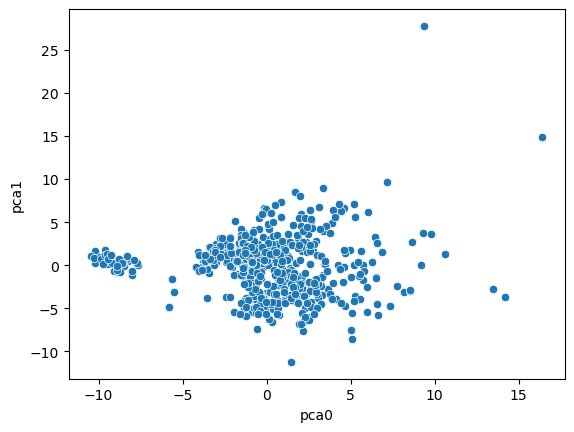

In [33]:
sns.scatterplot(data=principal_components_tables[f"2-components"], x="pca0", y="pca1");

We are observing a "trumpet" like structure to the plot with 2 principle conponents, which explain ~65 

#### Visualising 3D relationships (3 PCs) 

In [34]:
fig = px.scatter_3d(principal_components_tables["3-components"], x='pca0', y='pca1', z='pca2')
fig.show()

This look very similar to the 2D projection, maybe some "fingers" indicating similarities/cluster of players with similar outputs/roles

POTENTIAL - Where possible, look at the attempted stats rather for determining roles, as these stats show the work that the player has been asked to do, as could be more useful in determining the role they are playing. If a plyer is attempting a high number of long passes, and is unsuccessful, for this purpose, it is more important that he is categorised with other players who play long passes, but are potentially more successful, as attempting the passes indicates that these players are likely being deployed in the same role in their teams, and the difference is that one may just be more skilled than the other.

i.e. removing columns:

- short_passes_completed
- medium_passes_completed
- long_passes_completed
- dribblers_tackled
- take_ons_succeeded
- penalties_scored

and focusing on the attempted variants

In [35]:
pca_results = pd.DataFrame(
		data={
			"number_of_components" : number_of_components,
			"contribution": contributions,
			"explained_variance_ratio" : explained_variance_ratio,
	}
)

pca_results

,number_of_components,contribution,explained_variance_ratio
0,1,2.242254e-01,0.224225
1,2,1.832725e-01,0.407498
2,3,9.268093e-02,0.500179
3,4,5.374693e-02,0.553926
4,5,4.645194e-02,0.600378
5,6,3.904948e-02,0.639427
6,7,3.119832e-02,0.670625
7,8,2.698929e-02,0.697616
8,9,2.506577e-02,0.722686
9,10,2.341820e-02,0.746108


The relatively low explained variance ratio at 2 PCs may indicate the a more complex relationship is at play here, or a more complex method is required to identify the patterns that may be seen here

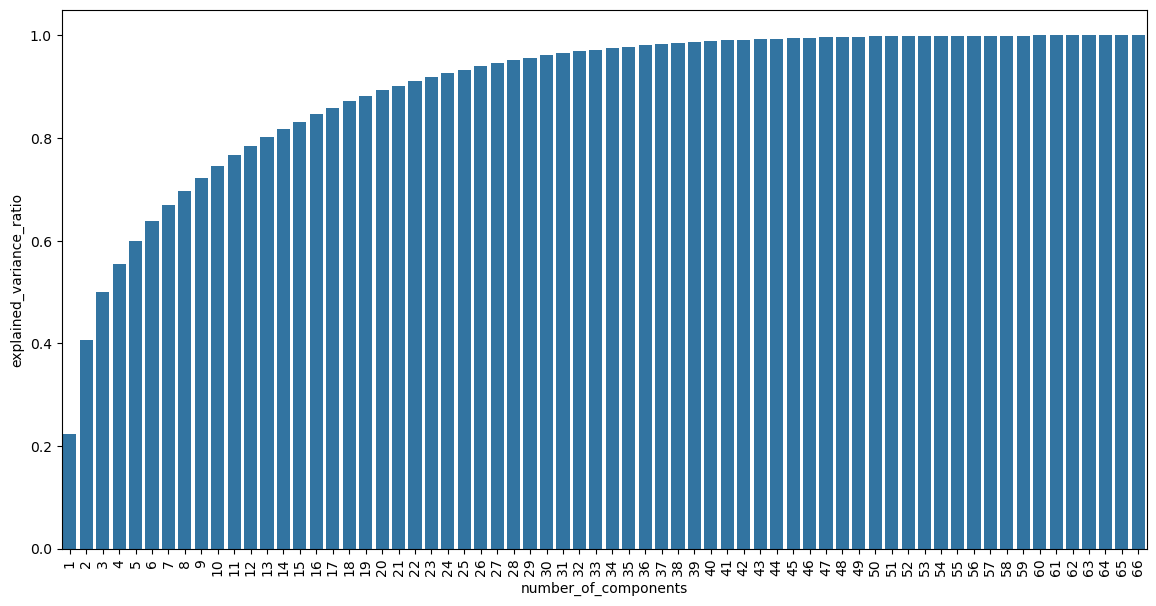

In [36]:
plt.figure(figsize=(14,7))
sns.barplot(data=pca_results, x="number_of_components", y="explained_variance_ratio")
plt.xticks(rotation=90);

Looking at where 80% of the data is explained by the principle components, so from 13 components

In [37]:
thirteen_pcs = principal_components_tables[f"13-components"][principal_components_tables[f"13-components"].index < len(clean_complete.columns)]
thirteen_pcs.index = scaler.feature_names_in_
thirteen_pcs

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12
goals,0.482228,0.428563,0.531147,-0.349131,0.091715,-0.204846,0.654352,0.609156,-1.062485,-0.202263,-0.472587,-0.160015,-0.158597
assists,1.772822,-2.128636,2.555162,4.396693,0.310152,-0.895261,-1.347297,1.039593,1.276410,-2.190250,0.432670,-0.879418,-0.186507
non_penalty_goals,-0.858682,-5.371382,0.575668,-0.457956,-0.647305,0.990690,-0.597595,-0.464620,-0.419454,0.594139,-0.374865,-0.185576,-0.506562
penalties_scored,2.952288,2.763270,-2.078540,-1.335041,3.568844,-3.596544,3.711515,2.998836,-0.807770,1.915673,-1.346842,-6.068014,3.691010
penalties_attempted,-9.661461,0.488224,-6.377211,2.165441,1.695982,-0.025725,0.038367,-0.035654,-0.081252,-0.426361,0.687324,0.107244,-0.164363
yellow_cards,-1.665807,1.135791,1.948615,-0.617817,-0.421958,0.503945,-1.227517,-2.360372,0.157202,0.462185,-0.253455,-0.623751,0.240207
red_cards,-0.836812,-3.957553,0.822987,-0.005728,-1.626976,0.916372,-0.933814,-1.024168,0.528337,-0.703847,0.272468,-0.273034,0.216100
expected_goals,5.112394,-8.500050,-3.214712,-7.973826,7.304865,-5.616628,-2.133523,1.225145,2.949479,-0.822113,0.289126,1.542005,0.076030
non_penalty_expected_goals,-2.563361,1.904838,1.042130,-1.225988,-0.561412,0.474012,-0.337495,0.716966,0.136925,0.727518,-0.670791,0.975439,-0.161610
expected_assisted_goals,1.411172,-0.283428,-0.244992,1.780041,-0.285374,-1.370873,1.166448,-0.338237,0.054977,0.667946,-0.678333,0.046304,0.361959


The above dataset and table shows the proportion of the variance that is explained as the 

### Clustering

#### k-means, where 2 <= k <= 11

/opt/homebrew/anaconda3/envs/pl-stats/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names

/opt/homebrew/anaconda3/envs/pl-stats/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names

/opt/homebrew/anaconda3/envs/pl-stats/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names

/opt/homebrew/anaconda3/envs/pl-stats/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names

/opt/homebrew/anaconda3/envs/pl-stats/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names

/opt/homebrew/anaconda3/envs/pl-stats/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning:

X does n

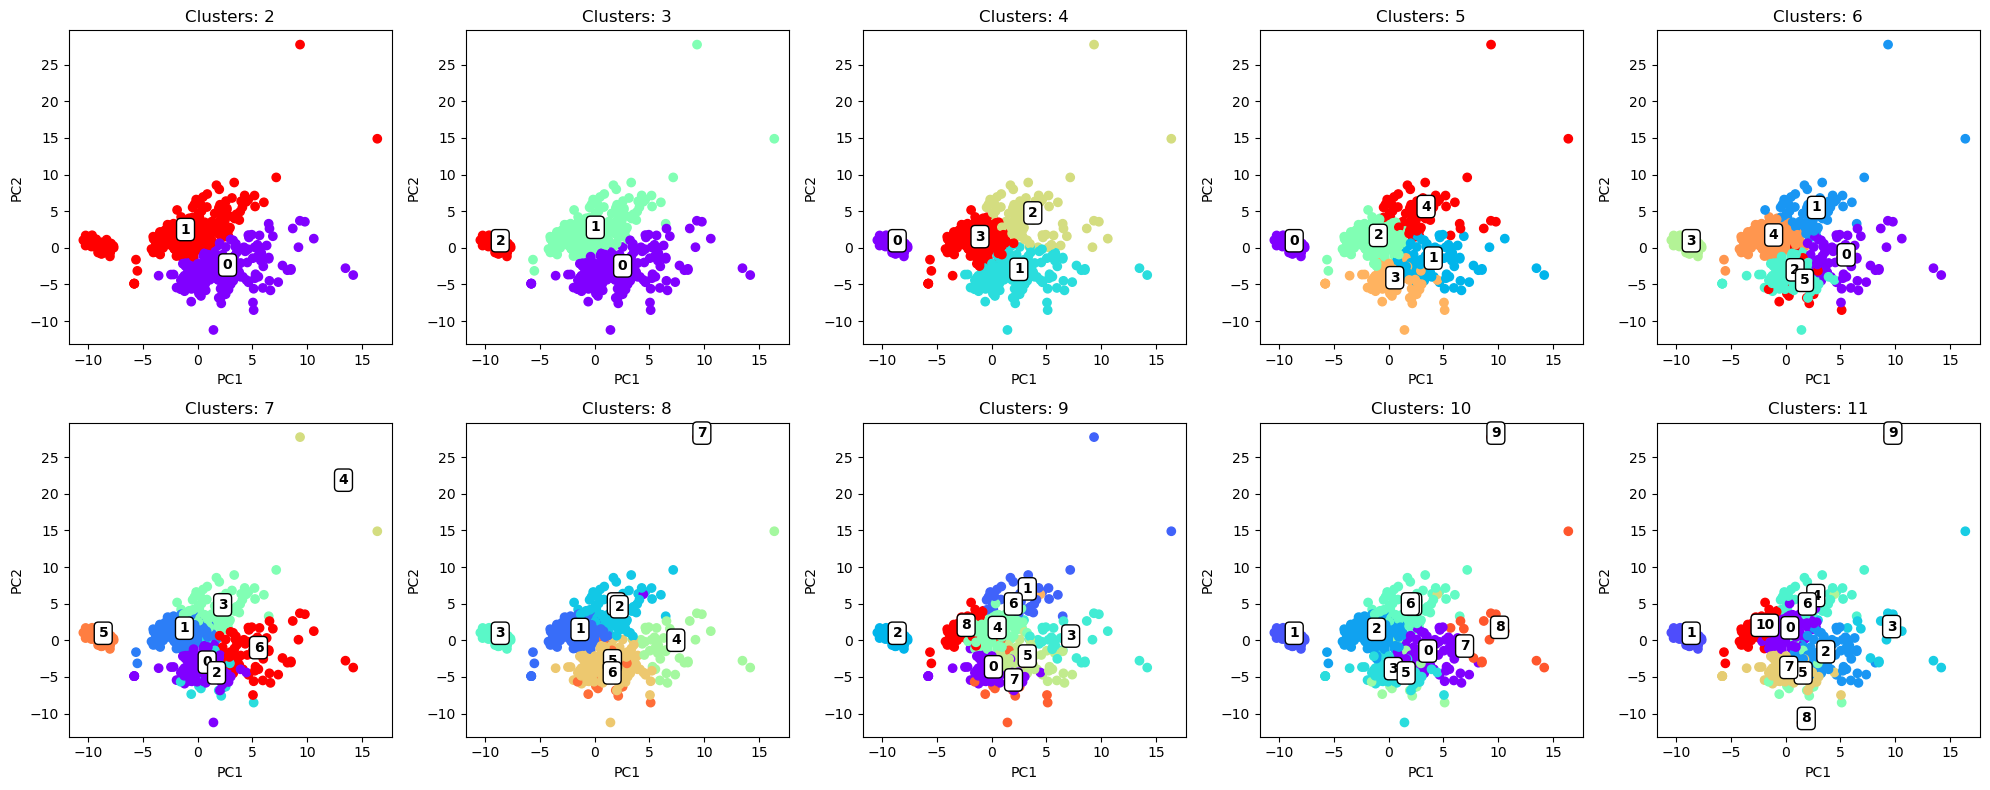

In [38]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8)) # Adjust the subplot layout based on your preference

number_of_clusters = []
number_of_datapoints = []
all_cluster_centres = []

representative_points = {}
players_by_cluster_df = {}

for k, ax in zip(range(2,12), axes.flatten()):
	k_means = KMeans(n_clusters=k, n_init = 100)
	k_means.fit(standardized_named)
	k_means_labels = k_means.fit_predict(standardized_named)

	number_of_clusters.append(k)

	# computing cluster centres based on the same pca method used on the dataset
	pca = PCA(n_components = 2, random_state=938)
	principal_components = pca.fit_transform(standardized_named)
	centre = pca.transform(k_means.cluster_centers_);
	all_cluster_centres.append(centre)

	# creating a dataset containing the players stats, with a label representing cluster subscription
	complete_no_nulls_copy = complete_no_nulls.copy(deep=True)
	complete_no_nulls_copy.loc[:, 'cluster'] = k_means_labels
	players_by_cluster_df[k] = complete_no_nulls_copy

	# identifying the number of records in each cluster
	unique_elements, counts = np.unique(k_means_labels, return_counts=True)
	number_of_datapoints.append(list(zip(unique_elements, counts)))
    
	# plotting the data and clusters
	ax.scatter(principal_components_tables[f"2-components"].loc[:, "pca0"], principal_components_tables[f"2-components"].loc[:, "pca1"], c=k_means.labels_, cmap='rainbow');
	ax.set_title(f'Clusters: {k}')

	ax.set_xlabel('PC1')
	ax.set_ylabel('PC2')

	# annotating each cluster
	for i, c in enumerate(centre):
		ax.annotate(f'{i}', (c[0], c[1]), fontsize=10, color='black', weight='bold',
			  bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

plt.tight_layout()
plt.show();

The above diagrams shows the clustering, considering 2 principal components, with different numbers of clusters, from 2 to 11

Identify datapoints in each cluster from the original set

In [39]:
players_by_cluster_df[6][players_by_cluster_df[6]["position"] == "GK"]["cluster"].value_counts()

cluster
3    38
Name: count, dtype: int64

In [40]:
players_by_cluster_df[6][players_by_cluster_df[6]["cluster"].isin([3])]["position"].value_counts()

position
GK    38
Name: count, dtype: int64

In my opinion, groupings seen with **4**, **5** and **6** clusters seem the most promising, where we are seeing some clearer groups with minimal overlap, but further investigation will follow to determine the optimal grouping of those presented.

### Post-Clustering EDA

#### Average stats in each cluster

In [41]:
pd.DataFrame(players_by_cluster_df[6].drop(columns=['position', 'player', 'team', "cluster"]).mean()).T

,matches_played,starts,minutes_played,90s,goals,assists,non_penalty_goals,penalties_scored,penalties_attempted,yellow_cards,red_cards,expected_goals,non_penalty_expected_goals,expected_assisted_goals,progressive_carries,progressive_passes,progressive_passes_recieved,total_passing_distance,total_progressive_passing_distance,short_passes_completed,short_passes_attempted,medium_passes_completed,medium_passes_attempted,long_passes_completed,long_passes_attempted,expected_assists,key_passes,passes_into_final_third,passes_into_penalty_area,crosses_into_penalty_area,shots,shots_on_target,average_shot_distance,shots_from_free_kicks,shots_from_penalties,touches,touches_in_defensive_penalty_area,touches_in_defensive_third,touches_in_middle_third,touches_in_attacking_third,touches_in_attacking_penalty_area,live_ball_touches,take_ons_attempted,take_ons_succeeded,times_tackled_during_take_on,carries,total_carrying_distance,progressive_carrying_distance,carries_into_final_third,carries_into_penalty_area,miscontrols,dispossessed,passes_received,tackles,tackles_won,defensive_third_tackles,middle_third_tackles,attacking_third_tackles,dribblers_tackled,dribbler_tackles_attempted,shots_blocked,passes_blocked,interceptions,clearances,errors_leading_to_shot,goals_against,shots_on_target_against,saves,wins,draws,losses,clean_sheets,penalties_faced,penalties_allowed,penalties_saved,penalties_missed
0,19.784091,15.833333,1423.630682,15.817424,0.104338,0.087304,0.099984,0.004354,0.007083,0.150577,0.006853,0.128675,0.123033,0.080927,1.740088,3.463254,3.973534,589.386892,211.608019,15.933864,18.489158,13.211946,16.155434,3.553047,6.796749,0.072041,0.832468,2.708262,0.680192,0.166166,1.176525,0.374789,3.19316,0.035825,0.004354,54.621564,4.533044,14.988939,25.46108,14.750001,2.033457,54.614481,1.536926,0.987888,0.547208,29.947838,161.977588,81.615183,1.336541,0.400638,1.509049,1.124573,34.903723,1.60045,1.050852,0.778396,0.633904,0.18815,0.561167,1.489285,0.299034,0.700678,1.021844,2.335283,0.045622,0.094121,0.285342,0.194461,0.02746,0.020113,0.024191,0.022255,0.006522,0.004914,0.001451,0.000157


In [42]:
mean_stats_by_cluster = pd.DataFrame()

In [43]:
for i in number_of_clusters:
	df = players_by_cluster_df[i]
	cluster_counts = df["cluster"].value_counts()
	df.loc[:, 'membership'] = df['cluster'].map(cluster_counts)
	mean_cluster_stats = df.drop(columns=['position', 'player', 'team']).groupby(["cluster"]).mean()
	mean_cluster_stats.loc[:, "total_clusters"] = i
	mean_cluster_stats = mean_cluster_stats.set_index('total_clusters', append=True)
	mean_stats_by_cluster = pd.concat([mean_stats_by_cluster, mean_cluster_stats])

In [44]:
mean_stats_by_cluster

,,matches_played,starts,minutes_played,90s,goals,assists,non_penalty_goals,penalties_scored,penalties_attempted,yellow_cards,red_cards,expected_goals,non_penalty_expected_goals,expected_assisted_goals,progressive_carries,progressive_passes,progressive_passes_recieved,total_passing_distance,total_progressive_passing_distance,short_passes_completed,short_passes_attempted,medium_passes_completed,medium_passes_attempted,long_passes_completed,long_passes_attempted,expected_assists,key_passes,passes_into_final_third,passes_into_penalty_area,crosses_into_penalty_area,shots,shots_on_target,average_shot_distance,shots_from_free_kicks,shots_from_penalties,touches,touches_in_defensive_penalty_area,touches_in_defensive_third,touches_in_middle_third,touches_in_attacking_third,touches_in_attacking_penalty_area,live_ball_touches,take_ons_attempted,take_ons_succeeded,times_tackled_during_take_on,carries,total_carrying_distance,progressive_carrying_distance,carries_into_final_third,carries_into_penalty_area,miscontrols,dispossessed,passes_received,tackles,tackles_won,defensive_third_tackles,middle_third_tackles,attacking_third_tackles,dribblers_tackled,dribbler_tackles_attempted,shots_blocked,passes_blocked,interceptions,clearances,errors_leading_to_shot,goals_against,shots_on_target_against,saves,wins,draws,losses,clean_sheets,penalties_faced,penalties_allowed,penalties_saved,penalties_missed,membership
cluster,total_clusters,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2,20.107981,13.516432,1229.051643,13.655869,0.208500,0.160954,0.199600,0.008899,0.014284,0.116350,0.003457,0.259099,0.247645,0.138855,2.758238,3.334819,7.450494,395.097837,96.450675,15.790339,19.094313,8.120581,11.125310,1.726443,3.283598,0.111615,1.325832,2.019011,1.005736,0.208395,2.135099,0.738021,5.405561,0.054077,0.008899,48.690631,0.974119,5.288915,20.831275,23.266132,3.962994,48.676347,2.782715,1.725924,1.052255,30.230181,179.758405,81.895451,2.063482,0.851960,2.729495,2.025857,36.309135,1.316785,0.835391,0.475908,0.586665,0.254212,0.344254,1.295339,0.080418,0.774917,0.551244,0.878453,0.018203,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,213.0
1,2,19.565079,17.400000,1555.203175,17.279048,0.033905,0.037502,0.032625,0.001280,0.002214,0.173721,0.009149,0.040484,0.038772,0.041757,1.051625,3.550100,1.622446,720.763301,289.476319,16.030914,18.079957,16.654678,19.556755,4.788180,9.172308,0.045282,0.498859,3.174327,0.460063,0.137612,0.528346,0.129176,1.697155,0.023484,0.001280,58.632004,6.939555,21.548003,28.591710,8.991475,0.728722,58.629790,0.694534,0.488835,0.205700,29.756920,149.954369,81.425668,0.844990,0.095458,0.683795,0.515134,33.953398,1.792262,1.196545,0.982936,0.665847,0.143479,0.707841,1.620430,0.446860,0.650479,1.340060,3.320378,0.064162,0.157765,0.478288,0.325954,0.046028,0.033713,0.040549,0.037304,0.010932,0.008236,0.002432,0.000263,315.0
0,3,19.723005,13.239437,1203.769953,13.374648,0.203881,0.158865,0.195259,0.008622,0.014006,0.116669,0.003457,0.255826,0.244567,0.137989,2.692919,3.250602,7.339681,380.107736,92.815669,15.202393,18.440061,7.793732,10.727201,1.667933,3.183560,0.110451,1.310286,1.950376,0.992697,0.205301,2.106118,0.725935,5.360020,0.050711,0.008622,47.224844,0.913903,4.973390,20.064790,22.868099,3.912137,47.210838,2.730849,1.693083,1.033230,29.383629,174.912545,79.263650,2.015350,0.842278,2.697685,2.000420,35.248924,1.284633,0.813732,0.457823,0.573092,0.253717,0.326580,1.256602,0.076945,0.755267,0.527208,0.836581,0.016836,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,213.0
1,3,19.783394,17.256318,1541.061372,17.122022,0.042108,0.043968,0.040438,0.001669,0.002731,0.190386,0.010404,0.048554,0.046458,0.047801,1.246119,4.100823,1.930230,740.437156,257.553955,18.431356,20.809846,18.112844,21.453567,4.232643,7.668995,0.052188,0.576950,3.572595,0.531790,0.158869,0.623016,0.156190,1.963715,0.029294,0.001669,63.290244

In [45]:
mean_stats_by_cluster.xs(6, level=1)

,matches_played,starts,minutes_played,90s,goals,assists,non_penalty_goals,penalties_scored,penalties_attempted,yellow_cards,red_cards,expected_goals,non_penalty_expected_goals,expected_assisted_goals,progressive_carries,progressive_passes,progressive_passes_recieved,total_passing_distance,total_progressive_passing_distance,short_passes_completed,short_passes_attempted,medium_passes_completed,medium_passes_attempted,long_passes_completed,long_passes_attempted,expected_assists,key_passes,passes_into_final_third,passes_into_penalty_area,crosses_into_penalty_area,shots,shots_on_target,average_shot_distance,shots_from_free_kicks,shots_from_penalties,touches,touches_in_defensive_penalty_area,touches_in_defensive_third,touches_in_middle_third,touches_in_attacking_third,touches_in_attacking_penalty_area,live_ball_touches,take_ons_attempted,take_ons_succeeded,times_tackled_during_take_on,carries,total_carrying_distance,progressive_carrying_distance,carries_into_final_third,carries_into_penalty_area,miscontrols,dispossessed,passes_received,tackles,tackles_won,defensive_third_tackles,middle_third_tackles,attacking_third_tackles,dribblers_tackled,dribbler_tackles_attempted,shots_blocked,passes_blocked,interceptions,clearances,errors_leading_to_shot,goals_against,shots_on_target_against,saves,wins,draws,losses,clean_sheets,penalties_faced,penalties_allowed,penalties_saved,penalties_missed,membership
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,20.276316,14.368421,1292.368421,14.352632,0.178632,0.215449,0.173218,0.005414,0.007536,0.107556,0.003053,0.231990,0.225660,0.210785,4.399487,5.202095,9.417045,590.611825,149.067202,22.170917,25.137485,12.597318,16.071318,2.655268,4.738172,0.169922,1.823148,3.216751,1.609601,0.308129,2.425837,0.787613,8.482734,0.081773,0.005414,63.193068,0.975279,6.605329,26.538398,30.965867,4.741849,63.185532,4.183582,2.719990,1.456713,41.172268,266.917195,131.415996,3.395165,1.285479,2.729166,2.226698,48.320799,1.497036,0.916610,0.657759,0.497624,0.341653,0.400425,1.441307,0.055928,0.809679,0.747324,0.795355,0.017386,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,76.0
1,21.153846,17.974359,1614.910256,17.944872,0.046181,0.073252,0.045046,0.001135,0.004529,0.150500,0.012007,0.055589,0.052320,0.077888,1.904610,6.428307,2.922566,1102.898552,361.856097,28.480486,31.167907,27.930163,31.485827,5.622432,9.067272,0.091052,0.962694,5.806056,0.871986,0.185203,0.780052,0.196712,1.967049,0.042769,0.001135,84.958486,3.416130,21.866485,48.288067,15.586903,1.031769,84.953957,1.014908,0.748228,0.266680,48.974641,239.180041,136.311958,1.572663,0.184862,0.874839,0.775621,58.848759,2.281739,1.619908,1.038734,0.958910,0.284096,0.880487,2.026266,0.330561,0.819869,1.329619,2.853349,0.053705,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,78.0
2,18.312500,11.562500,1064.523438,11.830469,0.181479,0.129734,0.180428,0.001051,0.005306,0.123090,0.003559,0.244766,0.240484,0.094315,1.808125,2.201467,6.148040,272.179806,64.791551,11.644885,15.043554,5.321152,8.033759,1.166100,2.425939,0.074566,1.009638,1.256486,0.648918,0.158500,1.836883,0.637309,3.890594,0.031228,0.001051,39.139637,0.918727,4.408775,16.811785,18.480161,3.316077,39.134331,1.970853,1.154662,0.814394,23.210198,127.532460,52.601729,1.303142,0.587995,2.710482,1.898146,28.348609,1.221892,0.791246,0.372888,0.644065,0.204940,0.314999,1.199094,0.088293,0.731108,0.429402,0.895395,0.017788,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,128.0
3,20.131579,20.000000,1800.000000,20.000000,0.000000,0.002078,0.000000,0.000000,0.000000,0.050461,0.000000,0.000000,0.000000,0.002547,0.000000,0.007674,0.000000,661.374716,542.548718,1.828551,1.847766,7.857487,7.961504,9.165714,20.691415,0.001465,0.016754,0.655887,0.010296,0.000000,0.000693,0.000000,0.009349,0.000000,0.000000,32.892003,27.499490,32.490844,0.4

#### Calculate the top stats for each cluster

In [46]:
number_of_clusters = 6

data = scaler.fit_transform(mean_stats_by_cluster.xs(number_of_clusters, level=1))
df = pd.DataFrame(data, columns=scaler.feature_names_in_)

In [47]:
max_indices_df = pd.DataFrame(index=df.columns, columns=['cluster_with_max_value'])

number_of_features = 10

top_x_values_df = df.apply(lambda row: row.nlargest(number_of_features).index.tolist(), axis=1).apply(pd.Series)

top_x_values_df.columns = [f'top_{i + 1}' for i in range(number_of_features)]
top_x_values_df.index = [f'cluster_{i}' for i in range(number_of_clusters)]

top_x_values_df.T


,goals,assists,non_penalty_goals,penalties_scored,penalties_attempted,yellow_cards,red_cards,expected_goals,non_penalty_expected_goals,expected_assisted_goals,progressive_carries,progressive_passes,progressive_passes_recieved,total_passing_distance,total_progressive_passing_distance,short_passes_completed,short_passes_attempted,medium_passes_completed,medium_passes_attempted,long_passes_completed,long_passes_attempted,expected_assists,key_passes,passes_into_final_third,passes_into_penalty_area,crosses_into_penalty_area,shots,shots_on_target,average_shot_distance,shots_from_free_kicks,shots_from_penalties,touches,touches_in_defensive_penalty_area,touches_in_defensive_third,touches_in_middle_third,touches_in_attacking_third,touches_in_attacking_penalty_area,live_ball_touches,take_ons_attempted,take_ons_succeeded,times_tackled_during_take_on,carries,total_carrying_distance,progressive_carrying_distance,carries_into_final_third,carries_into_penalty_area,miscontrols,dispossessed,passes_received,tackles,tackles_won,defensive_third_tackles,middle_third_tackles,attacking_third_tackles,dribblers_tackled,dribbler_tackles_attempted,shots_blocked,passes_blocked,interceptions,clearances,errors_leading_to_shot,goals_against,shots_on_target_against,saves,clean_sheets,penalties_faced
0,0.079408,0.077038,0.079080,0.030868,0.029352,-0.003814,0.003864,0.082130,0.080783,0.146157,0.185387,0.171147,0.166812,0.050393,-0.083278,0.184391,0.193403,0.069352,0.085217,-0.094365,-0.127575,0.165188,0.150718,0.126507,0.166431,0.063161,0.148920,0.124686,0.066075,0.072290,0.030868,0.149216,-0.189430,-0.131059,0.148741,0.212707,0.143151,0.149151,0.149701,0.143414,0.102076,0.181311,0.181381,0.137785,0.159431,0.138957,0.116526,0.125267,0.192460,0.073193,0.068056,0.022125,0.060281,0.087952,0.027212,0.058684,-0.040166,0.083521,0.002917,-0.050396,-0.045786,-0.158586,-0.168046,-0.167059,-0.133338,-0.128376
1,-0.144450,-0.026400,-0.142153,-0.069522,-0.068943,0.013781,0.026858,-0.141988,-0.137702,-0.047091,-0.037538,0.136180,-0.141007,0.260364,0.215092,0.145804,0.129164,0.245611,0.242712,0.180400,0.139935,-0.017572,-0.039712,0.188302,-0.011698,0.000297,-0.146774,-0.135988,-0.041478,0.011572,-0.069522,0.222969,0.066028,0.204886,0.207840,-0.081190,-0.161997,0.223045,-0.091468,-0.063415,-0.106375,0.171203,0.114922,0.148247,-0.009490,-0.116936,-0.137684,-0.116892,0.158543,0.094595,0.108905,0.088217,0.075894,-0.005798,0.076181,0.059246,0.063092,0.004719,0.091624,0.132960,0.056269,0.011315,0.010910,0.010155,0.005394,0.011079
2,-0.049276,-0.042023,-0.046948,-0.035866,-0.032617,0.054593,0.013902,-0.054584,-0.052348,-0.110034,-0.110169,-0.043602,-0.085461,-0.114769,-0.196981,-0.026010,-0.009087,-0.026347,-0.013253,-0.204151,-0.209551,-0.112683,-0.066325,-0.044325,-0.095965,-0.000686,-0.081384,-0.078420,-0.032262,-0.069935,-0.035866,-0.041292,-0.216173,-0.070474,0.053238,-0.073111,-0.091244,-0.041237,-0.084816,-0.095746,-0.031264,-0.093872,-0.140568,-0.167830,-0.094601,-0.104141,-0.027249,-0.015235,-0.075399,0.216221,0.201340,0.208971,0.152526,0.018159,0.211401,0.223843,0.130217,0.105704,0.153847,0.118942,-0.021502,-0.246754,-0.257756,-0.253980,-0.193544,-0.210402
3,-0.224671,0.021129,-0.200918,-0.266907,-0.258245,-0.072516,-0.053902,-0.173483,-0.150126,0.086040,0.147860,-0.038046,0.045112,-0.075887,0.006169,-0.062443,-0.062008,-0.114322,-0.110444,0.017172,0.087209,0.020815,0.116337,-0.062806,0.086603,0.129856,-0.073430,-0.056951,0.048031,-0.061378,-0.266907,-0.056273,0.074664,-0.042369,-0.091951,0.073403,-0.055507,-0.055869,0.194613,0.175753,0.152630,-0.040293,0.074696,0.050883,0.091500,0.088518,0.055422,0.122168,-0.081315,0.216432,0.179794,0.151547,0.147004,0.150606,0.216558,0.173682,-0.088030,0.074268,-0.041059,-0.140351,-0.033810,0.125825,0.130072,0.127388,0.093563,0.109706
4,0.184899,0.068087,0.158100,0.276701,0.269441,-0.085002,-0.008637,0.147013,0.121971,0.065083,-0.109688,0.003494,-0.031205,0.033656,0.091898,-0.052476,-0.052415,0.017676,-0.003078,0.078909,0.113205,0.0411

## Next steps

- Analyse the usefulness of the **feature_to_pc_map** df, which contains the weights for each column to the PCs, could be used as the new features to measure the players by, after establishing the PC values that correspond to each cluster
	- Convert each row of the per 90 dataframe into a row identifying each player, all stats reduced to the 13 principal components, with the cluster membership included
- Decide optimal groupings, i.e. number of clusters
	- Define the key characteristics of these clusters (Principal components/raw stats)
	- Key players for comparison within each group
- Apply groupings to larger dataset and decide suitability
- Decide on a method to compare stats between the two playing teams, based on these groups
	- Coefficients to denote player contribution
		- Group similar stats
	- Use principal components for each group
		- instead of one column per group, determine the weight of each groups contribution to each stat, and output a single value for the stat per team, player
- Build a model to predict:
	- match outcome
		- Based on comparison between output of the different roles between the teams
		- Based on players selected to play and be on the bench
	- match facts
		- Based on all player stats from game
			- neural net?
			- simple regression?
- Create a dataset of compared stats, analyse the method of comparison by using this to predict the match outcome